#### We want to roughly assess the magnitude of the error induced by Connectom GNL when computing $R_{\text{eff}}$ with a Veraart2020 style acquisition scheme over a full brain. 

For this goal, we will generate a few simple voxel macro-architecture: single fiber, fanning single fiber, 90-crossing and isotropic;  
A few diameter distributions: single diameter small-medium-big and Liewald;  
Simple multicompartement model with a a set a "standard" in-vivo parameters $D_0 = 2$, $f_{in} = 0.5$, no-csf, $D_{ex} = (1, 0.5)$  
maybe standard ex-vivo later with same fractions and 1/4 diffusivities.

Veraart style acquisition: same 60 directions per shell with dense bvalue sampling in [0, 100]  
Connectom-like GNL: 100 centroid

Maybe gaussian noise later

In [9]:
import numpy as np
import pylab as pl
from dipy.data import get_sphere
from scipy.special import erf

In [5]:
# bvec generated from typical "electrostatic" repulsion method on the hemisphere 
# + "eddy" optimisation to maximise coverage of full sphere
# https://github.com/scilus/scilpy/blob/master/scripts/scil_generate_gradient_sampling.py
# scil_generate_gradient_sampling.py 60 dirscheme_60_eddy --eddy --b0_every 0 --bvals 1000 --fsl
bvecs = np.genfromtxt('dirscheme_60_eddy.bvec')

In [14]:
# desired bval in ms/um2
# will skip b0 and assume S(b0)=1 for now, might modify later when adding noise
bvals = np.linspace(5, 100, 20, endpoint=True)

In [15]:
bvals

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

In [23]:
# use Gmax and bmax to get delta=DELTA for Neuman formula
# let's assume Connectom Gmax
Gmax = 0.3e-6 # T/um
bmax = max(bvals) # ms/um2
gamma = 42.515e3 * 2*np.pi # T^-1 ms^-1
# b = (gamma*delta*G)^2 (DELTA-delta/3) --- DELTA:=delta --->
delta = ((3/2.)*(bmax/(gamma**2*Gmax**2)))**(1/3) # ms

In [24]:
delta

28.58478184078324

In [8]:
# sphere to sample macro ODF
sphere = get_sphere('repulsion724')#.subdivide(2)

In [10]:
# symmetrized "discretized" Von-Mises Fisher distribution

# dist on sphere
def sphPDF(k, mu, direc):
	# Generate the PDF for a Von-Mises Fisher distribution p=3
	# at locations direc for concentration k and mean orientation mu
	C3 = k / (2*np.pi*(np.exp(k)-np.exp(-k)))
	tmp = np.exp(k*np.dot(direc,mu[:, None])).squeeze()
	return C3*tmp

# antipodally symetric
def sphPDF_sym(k, mu, direc, norm=False):
	d1 = sphPDF(k, mu, direc)
	d2 = sphPDF(k, mu, -direc)
	dd1 = (d1+d2)/2.
	if norm:
		dd1 = dd1/dd1.sum()
	return dd1

In [11]:
# A few ODFs
ODFs = []

# sharp (concentration=16) single fiber aligned in Y
ODF = sphPDF_sym(16, np.array([0,1,0]), sphere.vertices, norm=True)
ODFs.append(ODF)

# wide (concentration=4) single fiber aligned in Y
ODF = sphPDF_sym(4, np.array([0,1,0]), sphere.vertices, norm=True)
ODFs.append(ODF)

# sharp (concentration=32) 50/50 90degree 2-fiber crossing in aligned in X-Z plane
ODF1 = sphPDF_sym(32, np.array([1,0,0]), sphere.vertices, norm=True)
ODF2 = sphPDF_sym(32, np.array([0,0,1]), sphere.vertices, norm=True)
ODF = ODF1+ODF2
ODFs.append(ODF/ODF.sum())
            
# isotropic
ODFs.append((1/sphere.vertices.shape[0])*np.ones(sphere.vertices.shape[0]))

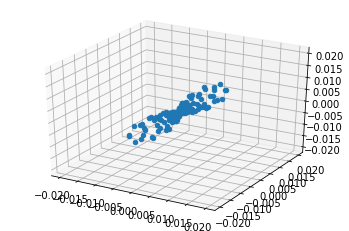

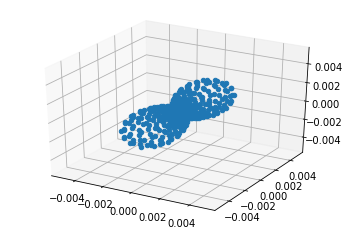

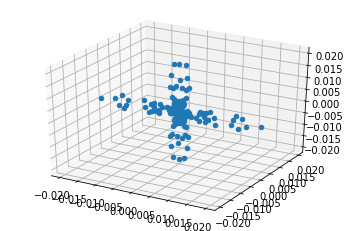

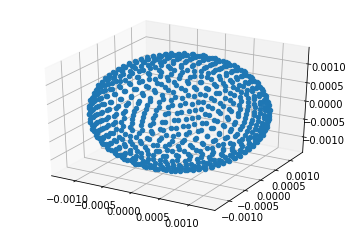

In [12]:
# ODFs viz
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as pl

for i in range(len(ODFs)):
    fig = pl.figure()
    ax = fig.add_subplot(111, projection='3d')

    scaled_pts = ODFs[i][:,None]*sphere.vertices
    ax.scatter(scaled_pts[:,0], scaled_pts[:,1], scaled_pts[:,2], depthshade=False)
    vizlim = (-np.abs(scaled_pts).max(), np.abs(scaled_pts).max())
    ax.set_xlim(vizlim)
    ax.set_ylim(vizlim)
    ax.set_zlim(vizlim)
    

pl.show('equal')

In [16]:
# diameter distribution
p_diam = np.array([1.])
diam = np.array([3.]) # um

In [17]:
# microstructure model
# for each direction in ODF, signal is modeled as f_in*S_in + (1-f_in)*S_ex
# S_in is a combinaison of 1D gauss parallel and Neuman formula perpendicular
# S_ex is an axisymmetric tensor
f_in = 0.5
D_0 = 2 # um2/ms
D_para = 1 # um2/ms
D_perp = 0.5 # um2/ms

In [ ]:
# # Signal generation functions

# ## non spherical mean signal generation
# def genSig_intra(b, D):
#     # 1D gaussian
# 	return np.exp(-b*D)

# def genSig_extra(pb, b, D_para, D_perp):
#     # axisymetric tensor; "zepplin"
# 	return np.exp(-pb*D_para - (b-pb)*D_perp)

# # stick + tensor
# def genSig_1orientation(pb, b, D_in, D_para, D_perp, f_in):
# 	f_ex = 1 - f_in
# 	S_in = genSig_intra(pb, D_in)
# 	S_ex = genSig_zep(pb, b, D_para, D_perp)
# 	return f_in*S_in + f_ex*S_ex